<a href="https://colab.research.google.com/github/alexandreherculano/k_means_constraineds_cluster_GEO/blob/main/k_means_constraineds_cluster_GEO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#instalar e importar bibliotecas
!pip install geopandas
!pip install k-means-constrained
!pip install folium
import pandas as pd
import geopandas as gpd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import random
import folium
%matplotlib inline
from k_means_constrained import KMeansConstrained
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

     |████████████████████████████████| 972kB 5.7MB/s 
     |████████████████████████████████| 14.8MB 305kB/s 
     |████████████████████████████████| 6.5MB 49.4MB/s 
     |████████████████████████████████| 563kB 5.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 14.0MB 327kB/s 
     |████████████████████████████████| 133kB 54.1MB/s 
     |████████████████████████████████| 1.0MB 42.6MB/s 
  Created wheel for k-means-constrained: filename=k_means_constrained-0.5.1-cp36-cp36m-linux_x86_64.whl size=1414410 sha256=005f347d4a6f56ff8676ebd42328a8188172981b5ce1fffa54ba45a8cc8cf5bc
  Stored in directory: /root/.cache/pip/wheels/0d/3a/06/690da6322330844514b57c3f0954a76b6e0102f77420b93bb9
Successfully built k-means-constrained
ERROR: tensorflow-metadata 0.27.0 has requirement absl-py<0.11,>=0.9, but you'll have absl-py 0.11.0 which is incompatible.
  Found existing installa

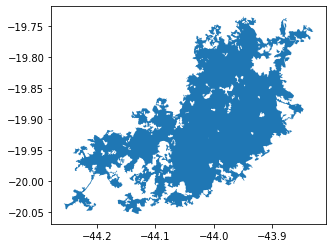

In [ ]:
#importar mancha urbana de Belo Horizonte - MG
belo_horizonte = gpd.read_file('/content/mancha_urbana_belo_horizonte_mg.shp')
#projetar em WGS 84
belo_horizonte.to_crs(epsg='4326', inplace=True)
#plotar Belo Horizonte - MG
belo_horizonte.plot()
plt.show()

,0,cliente_id
0,POINT (-43.90912 -19.87256),cliente_1
1,POINT (-43.97923 -19.89616),cliente_2
2,POINT (-43.96773 -19.82160),cliente_3
3,POINT (-43.91374 -19.83088),cliente_4
4,POINT (-44.04174 -19.94807),cliente_5


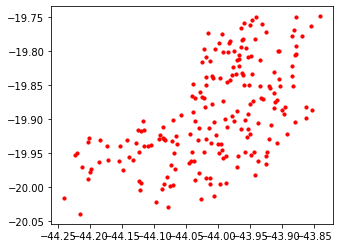

In [ ]:
#definir função para gerar pontos de clientes fictícios (pontos aleatórios)
def pontos_aleatorios(number, polygon):
    pontos = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            pontos.append(point)
            i += 1
    return pontos

#gerar GeoDataFrame com 200 pontos aleatórios no interior da mancha de Belo Horizonte - MG
aleatorios = pontos_aleatorios(200, belo_horizonte.iloc[0].geometry)
pontos_clientes = gpd.GeoDataFrame(aleatorios, geometry = 0)
pontos_clientes.crs = ('epsg:4326')

#criar coluna de id do cliente
pontos_clientes['cliente_id'] = 'cliente_' + (pontos_clientes.index + 1).astype('str')

#plotar pontos aleatórios
pontos_clientes.plot(color='r', markersize=10)
#top 5
pontos_clientes.head()

In [ ]:
#adicionar colunar de latitude e longitude
pontos_clientes['long'] = pontos_clientes.geometry.x
pontos_clientes['lat'] = pontos_clientes.geometry.y

#definir variáveis de entrada no modelo
X = pontos_clientes[['long','lat']]

#definir quantidade de clusters (ex: 7 vendedores ou equipes)
num_clusters = 7

cluster_geo = KMeansConstrained(n_clusters = num_clusters,
                                size_min = int(pontos_clientes.index.size / num_clusters - 1),
                                size_max = int(pontos_clientes.index.size / num_clusters + 1)).fit(X)

pontos_clientes['cl_vendedor'] = cluster_geo.labels_ + 1

In [ ]:
pontos_clientes['cl_vendedor'].nunique()

7

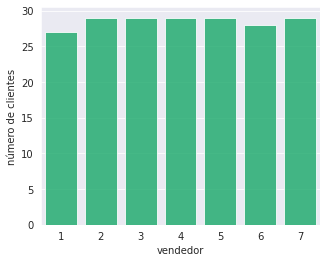

In [ ]:
#plot de dimensão dos cluester (número de clientes de clientes por vendedor)
sns.set_style('darkgrid')
ax = plt.figure(figsize=(5,4))
sns.countplot(x = pontos_clientes['cl_vendedor'], data = pontos_clientes, color='#00C06C', alpha=0.8)
plt.xlabel('vendedor')
plt.ylabel('número de clientes')
plt.show()

In [ ]:
#criar mapa
mapa_1 = folium.Map(location=[float(belo_horizonte.geometry.centroid.y), float(belo_horizonte.geometry.centroid.x)], 
                    tiles='openstreetmap', 
                    zoom_start=11)

#adicionar feição camada de Belo Horizonte - MG
Choropleth(belo_horizonte.__geo_interface__,
           fill_color = '#00CDA4',
           fill_opacity = 0.25
          ).add_to(mapa_1)

#definir função para categorização em cores de cluster por vendedor
def cor(val):
    if val == 1:
        return '#FF0000' #vermelho
    elif val == 2:
        return '#0000FF' #azul
    elif val == 3:
        return '#3AFF00' #verde 
    elif val == 4:
        return '#FFE800' #amarelo
    elif val == 5:
        return '#FF45C7' #rosa
    elif val == 6:
        return '#9B00FF' #roxo
    elif val == 7:
        return '#FFA63B' #laranja

#adicionar feição clientes
for i in range(0, len(pontos_clientes)):
    Circle(
        location=[pontos_clientes.iloc[i]['lat'], pontos_clientes.iloc[i]['long']],
        fill_opacity = 0.5,
        fill = True,
        color = cor(pontos_clientes.iloc[i]['cl_vendedor']),
        radius=20).add_to(mapa_1)

#plotar mapa
mapa_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [108]:
#criar mapa
mapa_2 = folium.Map(location=[float(belo_horizonte.geometry.centroid.y), float(belo_horizonte.geometry.centroid.x)], 
                    tiles='openstreetmap', 
                    zoom_start=11)

#adicionar feição camada de Belo Horizonte - MG
Choropleth(belo_horizonte.__geo_interface__,
           fill_color = '#00CDA4',
           line_opacicty = 0.25,
           fill_opacity = 0.15           
          ).add_to(mapa_2)

#criar polígono dos clusters por vendedor (envoltória convexa)
poligono_cluster = pontos_clientes.dissolve(by = 'cl_vendedor').convex_hull

#adicionar feição camada de Belo Horizonte - MG
Choropleth(geo_data = poligono_cluster,
           columns='cl_vendedor',
           data = poligono_cluster,
           line_weight = 2.5,
           fill_opacity = 0,
           fill_color = 'YlOrRd',
          ).add_to(mapa_2)

#adicionar feição clientes
for i in range(0, len(pontos_clientes)):
    Circle(
        location=[pontos_clientes.iloc[i]['lat'], pontos_clientes.iloc[i]['long']],
        fill_opacity = 0.5,
        fill = True,
        color = cor(pontos_clientes.iloc[i]['cl_vendedor']),
        radius=20).add_to(mapa_2)

#plotar mapa
mapa_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
